In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import DiscreteHMCGibbs, MCMC, NUTS
import time

In [2]:
# Toy Example
A = jnp.array([
    [0, 1, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 0, 1, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 0, 1, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 0, 1, 0, 0, 0, 0, 0],
    [1, 1, 1, 1, 0, 1, 0, 0, 0, 0],
    [0, 0, 0, 0, 1, 0, 1, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 0, 1, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 0, 1, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 0, 1],
    [0, 0, 0, 0, 0, 1, 1, 1, 1, 0]])
Z = jnp.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1])
K = 2

In [3]:
# NumPyro MCMC Model
def model(A, K):
    # Network Nodes
    n = A.shape[0]

    # Block Matrix Eta
    with numpyro.plate("eta1", K):
        with numpyro.plate("eta2", K):
            eta = numpyro.sample("eta", dist.Beta(1., 1.))

    # Group Memberships (Using a Multinomial Model)
    membership_probs = numpyro.sample("z_probs", dist.Dirichlet(concentration=jnp.ones(K)))
    with numpyro.plate("membership", n):
       sampled_memberships = numpyro.sample("sampled_z", dist.Categorical(probs=membership_probs))
       sampled_memberships = jax.nn.one_hot(sampled_memberships, K)

    # Adjacency Matrix
    p = jnp.matmul(jnp.matmul(sampled_memberships, eta), sampled_memberships.T)
    with numpyro.plate("rows", n):
      with numpyro.plate("cols", n):
            A_hat = numpyro.sample("A_hat", dist.Bernoulli(p), obs=A)

In [4]:
# Inference
kernel = DiscreteHMCGibbs(NUTS(model))
mcmc = MCMC(kernel, num_warmup=1500, num_samples=2500)
mcmc.run(jax.random.PRNGKey(0), A, K)
mcmc.print_summary()
Z_infer = mcmc.get_samples()["sampled_z"]
Z_infer = Z_infer[-1]
print("Inference Result", Z_infer)
print("Original Memberships", Z)

sample: 100%|██████████| 4000/4000 [00:07<00:00, 562.54it/s, 7 steps of size 5.88e-01. acc. prob=0.94] 

                  mean       std    median      5.0%     95.0%     n_eff     r_hat
    eta[0,0]      0.78      0.08      0.78      0.65      0.90   3646.00      1.00
    eta[0,1]      0.07      0.05      0.06      0.01      0.15   3062.13      1.00
    eta[1,0]      0.08      0.05      0.06      0.00      0.15   3438.60      1.00
    eta[1,1]      0.78      0.08      0.79      0.66      0.90   3467.65      1.00
sampled_z[0]      0.00      0.00      0.00      0.00      0.00       nan       nan
sampled_z[1]      0.00      0.00      0.00      0.00      0.00       nan       nan
sampled_z[2]      0.00      0.00      0.00      0.00      0.00       nan       nan
sampled_z[3]      0.00      0.00      0.00      0.00      0.00       nan       nan
sampled_z[4]      0.00      0.00      0.00      0.00      0.00       nan       nan
sampled_z[5]      1.00      0.00      1.00      1.00      1.00   

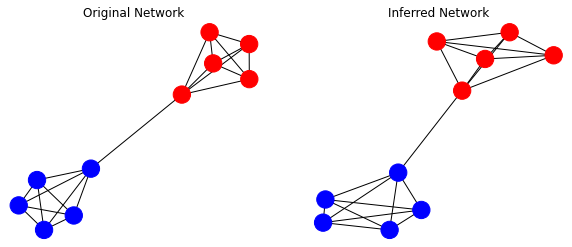

In [5]:
# Visualization
G = nx.from_numpy_matrix(A)
plt.figure(figsize=(10,4))
plt.subplot(121)
nx.draw(G, pos=nx.spring_layout(G), node_color=["red" if x==1 else "blue" for x in Z])
plt.title("Original Network")

plt.subplot(122)
nx.draw(G, pos=nx.spring_layout(G), node_color=["red" if x==1 else "blue" for x in Z_infer])
plt.title("Inferred Network")
plt.show()

In [6]:
# Runtime Comparison: General & Iterative
def get_mean_runtime(num_iters):
    durs = []
    for i in range(num_iters):
        kernel = DiscreteHMCGibbs(NUTS(model))
        mcmc = MCMC(kernel, num_warmup=1500, num_samples=2500)
        start = time.time()
        mcmc.run(jax.random.PRNGKey(0), A, K)
        end = time.time()
        duration = end - start
        durs.append(duration)

    mean_dur = sum(durs)/num_iters
    
    return mean_dur, durs

mean_dur, durs = get_mean_runtime(10)
print("\nMean Duration: ", mean_dur)
print("\nMean Iters/s: ", 447)

sample: 100%|██████████| 4000/4000 [00:07<00:00, 534.00it/s, 7 steps of size 5.88e-01. acc. prob=0.94] 

Mean Duration:  7.531538462638855

Mean Iters/s:  447
